In [5]:
# %load_ext autotime
# !pip install autotime
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import torch
print(f"CUDA available: {torch.cuda.is_available()}")

CUDA available: False


In [7]:
from pathlib import Path
import os
import warnings
import pandas as pd
import numpy as np
import esm
import biotite.structure.io as bsio
from collections import defaultdict

from proteinttt.models.esmfold import ESMFoldTTT, DEFAULT_ESMFOLD_TTT_CFG
from proteinttt.utils.structure import calculate_tm_score, lddt_score

pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 100)
pd.set_option("max_colwidth", 100)

base_path = Path("/scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures")
SABDAB_SUMMARY_PATH = base_path / Path("summary_HLchain_after.tsv")
OUTPUT_PDB = base_path / Path('predicted_structures')
PDB_FILES_PATH = base_path / Path("chothia")
OUTPUT_SUMMARY = base_path / Path("summary_HLchain_after.tsv")

os.makedirs(OUTPUT_PDB, exist_ok=True)

print(f"Summary file: {SABDAB_SUMMARY_PATH}")
print(f"PDB files path: {PDB_FILES_PATH}")
print(f"Output will be saved to: {OUTPUT_PDB}")

Summary file: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/summary_HLchain_after.tsv
PDB files path: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/chothia
Output will be saved to: /scratch/project/open-32-14/pimenol1/ProteinTTT/ProteinTTT/all_structures/predicted_structures


In [ ]:
df = pd.read_csv(SABDAB_SUMMARY_PATH, sep="\t", low_memory=False)
print(f"Entries in summary: {len(df):,}")
df.head(5)

Entries in summary: 33,423


,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before,length,pLDDT_after,tm_score_after,LDDT_after
0,8ykd,S,Hchain,VQLVESGGGLVQPGGSRKLSCSASGFAFSSFGMHWVRQAPEKGLEWVAYISSGSGTIYYADTVKGRFTISRDDPKNTLFLQMTSLRSEDTAMYYCV...,"['2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '...","['H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16'...",2.9,83.441442,0.21743,0.279889,233,NaN,NaN,NaN
1,8ykd,s,Lchain,DIVMTQATSSVPVTPGESVSISCRSSKSLLHSNGNTYLYWFLQRPGQSPQLLIYRMSNLASGVPDRFSGSGSGTAFTLTISRLEAEDVGVYYCMQH...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",2.9,89.154623,0.32104,0.363930,111,NaN,NaN,NaN
2,8ykd,N,Hchain,QVQLQESGGGLVQPGGSLRLSCAASGFTFSNYKMNWVRQAPGKGLEWVSDISQSGASISYTGSVKGRFTISRDNAKNTLYLQMNSLKPEDTAVYYC...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['H1', 'H2', 'H3', 'H4', 'H5', 'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15',...",2.9,83.731851,0.31661,0.372456,127,NaN,NaN,NaN
3,9eje,H,Hchain,LVKPSETLSLTCSVSGESISSGGYYWTWIRQHPGKGLEWIGNIFDTGSTHYSPSLKTRLTISIDTSKNQFYLRLNSATAADTAVYYCARVGYSLET...,"['11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26',...","['H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24...",4.18,80.446852,0.36705,0.284755,117,NaN,NaN,NaN
4,9eje,L,Lchain,DIVMTQSPLSLPVTPGEPASISCRSSQSLLHSNGYTYLDWYLQKPGQSPQLLIYLASNRASGVPDRFSGSGSGTYFTLKISRVEAEDVGVYYCMQA...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['L1', 'L2', 'L3', 'L4', 'L5', 'L6', 'L7', 'L8', 'L9', 'L10', 'L11', 'L12', 'L13', 'L14', 'L15',...",4.18,89.447657,0.34342,0.328972,112,NaN,NaN,NaN


In [ ]:
df.query("pLDDT_before.isna()").shape[0]
# df['length'] = df['sequence'].str.len()

17490

In [ ]:
# from proteinttt.utils.parsers import fetch_and_parse_sequences
# df_sequence = fetch_and_parse_sequences(df, PDB_FILES_PATH)
# df.to_csv(path_or_buf=base_path / "summary_HLchain_after.tsv", sep="\t", index=False)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using", device)

base_model = esm.pretrained.esmfold_v1().eval().to(device)

ttt_cfg = DEFAULT_ESMFOLD_TTT_CFG
ttt_cfg.steps = 20          
ttt_cfg.batch_size = 4           
ttt_cfg.seed = 0
# ttt_cfg.lr = 2e-4
model = ESMFoldTTT.ttt_from_pretrained(base_model,
                                       ttt_cfg=ttt_cfg,
                                       esmfold_config=base_model.cfg).to(device)

In [ ]:
def predict_structure(model, sequence, pdb_id, tag, out_dir=OUTPUT_PDB):
    with torch.no_grad():
        pdb_str = model.infer_pdb(sequence)

    if torch.cuda.is_available():
        torch.cuda.synchronize()
    
    out_path = out_dir / f"{pdb_id}_{tag}.pdb"
    out_path.write_text(pdb_str)
    
    struct = bsio.load_structure(out_path, extra_fields=["b_factor"])
    pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())
    
    try:
        tm_score = calculate_tm_score(
            pred_path=out_path,
            pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
    except Exception as e:
        print(f"Could not calculate TM-score for {pdb_id}: {e}")
        tm_score = np.nan
        
    try:
        lddt = lddt_score(pdb_ref=PDB_FILES_PATH / f"{pdb_id}.pdb", pdb_model=out_path)
    except Exception as e:
        # print(f"Could not calculate lDDT for {pdb_id}: {e}")
        lddt = np.nan
    
    return pLDDT, tm_score, lddt

In [ ]:
def fold_chain(sequence, pdb_id, *, model, tag, out_dir = OUTPUT_PDB):
    """
    Predict a structure for `sequence` with TTT
    return pLDDT.
    The PDB is written as <out_dir>/<pdb_id>_<tag>.pdb
    """
    model.ttt(sequence)
    pLDDT_after, tm_score_after, lddt = predict_structure(model, sequence, pdb_id, tag=f'{tag}_ttt', out_dir=out_dir)
    model.ttt_reset()
    return pLDDT_after, tm_score_after, lddt

## Before

In [7]:
num_of_low = 0
col = 'sequence'

In [ ]:
for i, row in df.iterrows():
    if pd.isna(row[col]) or pd.notna(row['pLDDT_before']) or row['length'] > 800:
        continue
    
    pdb_id = str(row.get("pdb"))
    
    seq = str(row[col]).strip().upper()
    tag = f'{row["chain"]}'

    if (OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb").exists():
        print(f"File {pdb_id} exists")
        struct = bsio.load_structure(OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb", extra_fields=["b_factor"])
        pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())
        try:
            tm_score = calculate_tm_score(
                pred_path=OUTPUT_PDB / f"{pdb_id}_{tag}_before_ttt.pdb",
                pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
        except Exception as e:
            print(f"Could not calculate TM-score for {pdb_id}: {e}")
            tm_score = np.nan
        lddt_before = np.nan
    else:
        try:
            pLDDT_before, tm_score_before, lddt_before = predict_structure(model, seq, pdb_id, tag=f'{tag}_before_ttt', out_dir=OUTPUT_PDB)
        except Exception as e:
            warnings.warn(f"{pdb_id}{tag}: {e}")
        
    df.at[i, f'pLDDT_before'] = pLDDT_before
    df.at[i, f'tm_score_before'] = tm_score_before
    df.at[i, 'LDDT_before'] = lddt_before
    if pLDDT_before < 70:
        num_of_low+=1
        print(pLDDT_before)
        df.to_csv(SABDAB_SUMMARY_PATH, sep="\t", index=False)
            
df.to_csv(SABDAB_SUMMARY_PATH, sep="\t", index=False)
print(num_of_low)

## After

In [ ]:
c = 0 
for i, row in df.iterrows():
    if row['pLDDT_before'] > 70 or pd.isna(row.get("pLDDT_before")) or row['length'] > 400 or pd.notna(row.get("pLDDT_after")):
        continue
    c+=1
    pdb_id = str(row.get("pdb"))

    if pd.isna(row[col]):
        continue
    
    tag = row["chain"]
    seq = str(row[col]).strip().upper()

    if (OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb").exists():
        print(f"File {pdb_id} exists")
        struct = bsio.load_structure(OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb", extra_fields=["b_factor"])
        pLDDT = float(np.asarray(struct.b_factor, dtype=float).mean())
        try:
            tm_score = calculate_tm_score(
                pred_path=OUTPUT_PDB / f"{pdb_id}_{tag}_ttt.pdb",
                pdb_path=PDB_FILES_PATH / f"{pdb_id}.pdb")
        except Exception as e:
            print(f"Could not calculate TM-score for {pdb_id}: {e}")
            tm_score = np.nan
        lddt_after = np.nan
    else:
        try:
            pLDDT_after, tm_score_after, lddt_after = fold_chain(seq, pdb_id, model=model, tag=tag)
        except Exception as e:
            warnings.warn(f"{pdb_id}{tag}: {e}")
            
    df.at[i, 'pLDDT_after'] = pLDDT_after
    df.at[i, 'tm_score_after'] = tm_score_after
    df.at[i, 'LDDT_after'] = lddt_after
            
    if c % 10 == 0:
        df.to_csv(OUTPUT_SUMMARY, sep="\t", index=False)
        
    print(f"pdb: {pdb_id}, pLDDT before:{row['pLDDT_before']}, plddt after:{row['pLDDT_after']}")


df.to_csv(OUTPUT_SUMMARY, sep="\t", index=False)

## Plots

Entries with pLDDT before and after: 88


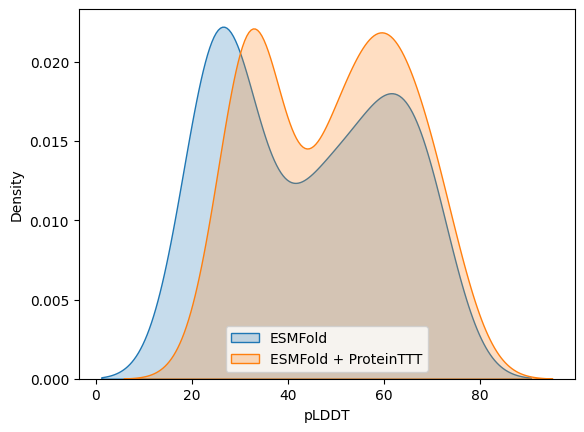

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sub_df = df.query("pLDDT_before.notna() and pLDDT_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['pLDDT_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['pLDDT_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('pLDDT')
plt.legend()
plt.show()

Entries with pLDDT before and after: 87


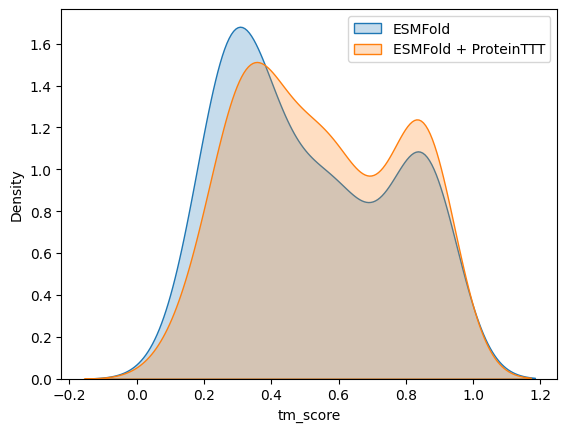

In [41]:
sub_df = df.query("tm_score_before.notna() and tm_score_after.notna()")
print(f"Entries with pLDDT before and after: {len(sub_df):,}")

sns.kdeplot(sub_df['tm_score_before'], label='ESMFold', fill=True)
sns.kdeplot(sub_df['tm_score_after'], label='ESMFold + ProteinTTT', fill=True)
plt.xlabel('tm_score')
plt.legend()
plt.show()

In [42]:
# plt.figure(figsize=(10, 6))
# # sns.scatterplot(x='Hchain_pLDDT_before', y='Hchain_tm_score_before', data=df, label='ESMFold', alpha=0.5)
# sns.scatterplot(x='Hchain_pLDDT_after', y='Hchain_tm_score_after', data=df, label='ESMFold + ProteinTTT', alpha=0.5)
# plt.xlabel('pLDDT')
# plt.ylabel('TM-score')
# plt.legend()
# plt.show()

In [ ]:
# rows = df.dropna(subset=['Hchain_pLDDT_before', 'Hchain_tm_score_before'])
# from scipy.stats import pearsonr
# pearsonr(rows['Hchain_pLDDT_after'], rows['Hchain_tm_score_after'])

In [43]:
# df['Hchain_tm_score_diff'] = df['Hchain_tm_score_after'] - df['Hchain_tm_score_before']
# plt.figure(figsize=(4, 5))
# plt.scatter(np.zeros_like(df['Hchain_tm_score_diff']), df['Hchain_tm_score_diff'], color='green')
# plt.ylabel('TM-score difference after and before ProteinTTT')

In [43]:
df['diff'] = df['tm_score_after'] - df['tm_score_before']
top_10_diff = df.nlargest(10, 'diff')
top_10_diff

,pdb,chain,chain_type,sequence,chothia_numbers,chothia_positions,resolution,pLDDT_before,tm_score_before,LDDT_before,length,pLDDT_after,tm_score_after,LDDT_after,diff
62,9jie,B,antigen_chain,APARPITNWRSGDVVWVTLPSAEYAQSQSAMGSHPAYWSEEATIINVATGQRAAVSSIKWDQVTLNGKALHKETHSGLVYYQLPLMGKINFWQQGT...,"['446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459...","['446', '447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459...",2.76,31.102555,0.32913,NaN,152.0,57.497692,0.77222,NaN,0.44309
63,9jif,A,antigen_chain,SRPFSVLRANDVLWLSLTAAEYDQSTYGSSTGPVYVSDSVTLVNVATGAQAVARSLDWTKVTLDGRPLSTIQQYSKTFFVLPLRGKLSFWEAGTTK...,"['459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472...","['459', '460', '461', '462', '463', '464', '465', '466', '467', '468', '469', '470', '471', '472...",2.79,45.110605,0.57835,NaN,147.0,63.063622,0.81220,NaN,0.23385
67,9jin,B,antigen_chain,PARPITNWRSGDVVWVTLPSAEYAQSQSAMGSHPAYWSEEATIINVATGQRAAVSSIKWDQVTLNGKALHKETHSGLVYYQLPLMGKINFWQQGTT...,"['447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460...","['447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460...",2.56,29.543080,0.44586,NaN,151.0,55.589418,0.67188,NaN,0.22602
134,9j8a,P,antigen_chain,PIDINTSE,"['1', '2', '4', '5', '6', '9', '10', '11']","['1', '2', '4', '5', '6', '9', '10', '11']",1.75,68.533934,0.19469,NaN,8.0,73.803115,0.37744,NaN,0.18275
150,8yry,A,antigen_chain,NADLSFLQWIREVNEFSTLPLPNLRVVRGTNSSHALRQLRLTQLTEILSGGVYIEKNDKLCHMDTIDWDNGRSCPPCHEVCKGRCWGPGSEDCQTL,"['71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '92', '93', '94',...","['71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '92', '93', '94',...",2.93,45.612158,0.43106,0.470527,96.0,50.417211,0.60171,NaN,0.17065
173,9oas,M,antigen_chain,DTITLPCRPAPPPHCSSNITGLILTRQGGYSNANTVIFRPSGGDWRDIARCQIAGTVVSTQLFLNGSLAEEEVVIRSENWTDNAKSICVQLATSVE...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...",2.79,28.791238,0.30612,NaN,169.0,32.485670,0.46343,NaN,0.15731
66,9jim,A,antigen_chain,PARPITNWRSGDVVWVTLPSAEYAQSQSAMGSHPAYWSEEATIINVATGQRAAVSSIKWDQVTLNGKALHKETHSGLVYYQLPLMGKINFWQQGTT...,"['447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460...","['447', '448', '449', '450', '451', '452', '453', '454', '455', '456', '457', '458', '459', '460...",2.86,29.543080,0.44633,NaN,151.0,50.630642,0.58345,NaN,0.13712
170,9oap,C,antigen_chain,DTITLPCRPAPPPHCSSNITGLILTRQGGYSNANTVIFRPSGGDWRDIARCQIAGTVVSTQLFLNGSLAEEEVVIRSEDWRDNAKSICVQLATSVE...,"['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...","['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '1...",2.8,29.192756,0.31464,NaN,169.0,32.811188,0.44274,NaN,0.12810
57,9ore,A,antigen_chain,KESYLEESCSTITEGYLSVLRTGWYTNVFTLEVGDVENLTCSDGPSLIKTELDLTKSALRELKTVSADQLRFVLGAIALGRATAAAVTAGVAIAKT...,"['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',...","['20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',...",4.13,42.021906,0.49674,0.201515,437.0,56.048990,0.61698,NaN,0.12024
154,9cfa,C,antigen_chain,DTITLPCRPAPPPHCSSNITGLILTRQGGYSNANTVIFRPSGGDWRDIARCQIAGTVVSTQLFLNGSLAEEEVVIRSEDWRDNAKSICVQLATSVE...,"['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...","['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',...",3.06,28.859807,0.33389,0.248793,170.0,32.116767,0.44244,NaN,0.10855
